This notebook intent is to analyze the properties of real networks.

Note that the datafile loaded in this notebook is located in a private bucket.

Reference: https://www.nature.com/articles/s41598-021-03625-w#additional-information

# Packages

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.stats import pearsonr
import GRNgene as gg
import cma
import numpy as np
import pickle as pkl
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
import functions as f
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

In [2]:
# Make sure it installs in the correct environment !
#!pip install fsspec
#!pip install gcsfs

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_degrees_log10(G: nx.DiGraph, plot_fit: bool = False):
    """
    Plot the total, in- and out- degree distribution of a network and optionally fit a power law.

    Parameters
    ----------
    G : nx.DiGraph
        Directed graph representing the gene regulatory network.
    plot_fit : bool, optional
        If True, fit and overlay a power-law curve on the degree distribution plot.
    """
    def fit_and_plot_loglog(ax, degrees, probabilities, label):
        """Fits log-log power law and plots the regression line."""
        mask = degrees > 0
        log_k = np.log10(degrees[mask])
        log_p = np.log10(probabilities[mask])
        #slope, intercept, *_ = linregress(log_k, log_p)
        slope, *_ = linregress(log_k, log_p)

        ax.plot(
            log_k,
            #intercept + slope * log_k,
            slope * log_k,
            'r--',
            label=f'Power law fit (slope={slope:.2f})'
        )
        ax.legend()
        return -slope  # power law exponent

    N = G.number_of_nodes()

    # Total degree
    degree_sequence = np.array([d for _, d in G.degree()])
    degrees, counts = np.unique(degree_sequence, return_counts=True)
    probabilities = counts / N

    # In-degree
    in_degree_sequence = np.array([d for _, d in G.in_degree()])
    in_degrees, in_counts = np.unique(in_degree_sequence, return_counts=True)
    in_probabilities = in_counts / N

    # Out-degree
    out_degree_sequence = np.array([d for _, d in G.out_degree()])
    out_degrees, out_counts = np.unique(out_degree_sequence, return_counts=True)
    out_probabilities = out_counts / N

    fig = plt.figure("Degree distribution", figsize=(8, 8))
    axgrid = fig.add_gridspec(3, 2)

    # --- Total degree ---
    ax0 = fig.add_subplot(axgrid[0, 0])
    ax0.scatter(np.log10(degrees[degrees > 0]), np.log10(probabilities[degrees > 0]), marker="o", color="b")
    ax0.set_title("Log10-Log10 Degree Distribution")
    ax0.set_ylabel("Log10 P(k)")
    ax0.set_xlabel("Log10 Degree k")

    if plot_fit:
        exponent = fit_and_plot_loglog(ax0, degrees, probabilities, "Degree")
        print(f"Full degree power law exponent: {exponent:.2f}")

    ax1 = fig.add_subplot(axgrid[0, 1])
    ax1.bar(degrees, counts)
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Number of Nodes")

    # --- In-degree ---
    ax2 = fig.add_subplot(axgrid[1, 0])
    ax2.scatter(np.log10(in_degrees[in_degrees > 0]), np.log10(in_probabilities[in_degrees > 0]), marker="o", color="b")
    ax2.set_title("Log10-Log10 In-Degree Distribution")
    ax2.set_ylabel("Log10 P(k)")
    ax2.set_xlabel("Log10 Degree k")

    if plot_fit:
        exponent = fit_and_plot_loglog(ax2, in_degrees, in_probabilities, "In-degree")
        print(f"In-degree power law exponent: {exponent:.2f}")

    ax3 = fig.add_subplot(axgrid[1, 1])
    ax3.bar(in_degrees, in_counts)
    ax3.set_title("In-Degree Histogram")
    ax3.set_xlabel("Degree")
    ax3.set_ylabel("Number of Nodes")

    # --- Out-degree ---
    ax4 = fig.add_subplot(axgrid[2, 0])
    ax4.scatter(np.log10(out_degrees[out_degrees > 0]), np.log10(out_probabilities[out_degrees > 0]), marker="o", color="b")
    ax4.set_title("Log10-Log10 Out-Degree Distribution")
    ax4.set_ylabel("Log10 P(k)")
    ax4.set_xlabel("Log10 Degree k")

    if plot_fit:
        exponent = fit_and_plot_loglog(ax4, out_degrees, out_probabilities, "Out-degree")
        print(f"Out-degree power law exponent: {exponent:.2f}")

    ax5 = fig.add_subplot(axgrid[2, 1])
    ax5.bar(out_degrees, out_counts)
    ax5.set_title("Out-Degree Histogram")
    ax5.set_xlabel("Degree")
    ax5.set_ylabel("Number of Nodes")

    fig.tight_layout()
    plt.show()



# Loading file

In [4]:
filepath = "../data/41598_2021_3625_MOESM5_ESM.xlsx"
file = pd.read_excel(filepath)

In [3]:
athaliana = (file["""Supplementary Table S1: Networks. A spreadsheet file with filtered networks"""].tolist()[2:], 
                       file["Unnamed: 1"].tolist()[2:], "Arabidopsis thaliana")  # noqa : E501
dmelanogaster = (file["Unnamed: 2"].tolist()[2:], 
                          file["Unnamed: 3"].tolist()[2:], "Drosophila Melanogaster")  # noqa : E501
ecoli = (file["Unnamed: 4"].tolist()[2:], 
                    file["Unnamed: 5"].tolist()[2:], "Escherichnia coli")  # noqa : E501
hsapiens = (file["Unnamed: 6"].tolist()[2:], 
               file["Unnamed: 7"].tolist()[2:], "Homo sapiens")  # noqa : E501
scerevisiae = (file["Unnamed: 8"].tolist()[2:], 
                           file["Unnamed: 9"].tolist()[2:], "Saccharomyces cerevisiae")  # noqa : E501

f.remove_nan_values(athaliana)
f.remove_nan_values(dmelanogaster)
f.remove_nan_values(ecoli)
f.remove_nan_values(hsapiens)
f.remove_nan_values(scerevisiae)

g_athaliana = f.create_graph(athaliana)
g_dmelanogaster = f.create_graph(dmelanogaster)
g_ecoli = f.create_graph(ecoli)
g_hsapiens = f.create_graph(hsapiens)
g_scerevisiae = f.create_graph(scerevisiae)

properties_athaliana = gg.network_properties(g_athaliana)
properties_dmelanogaster = gg.network_properties(g_dmelanogaster)
properties_ecoli = gg.network_properties(g_ecoli)
properties_hsapiens = gg.network_properties(g_hsapiens)
properties_scerevisiae = gg.network_properties(g_scerevisiae)

NameError: name 'file' is not defined

# Individual network analysis

## Arabidopsis Thaliana

Fitted power law parameter: b = -3.86


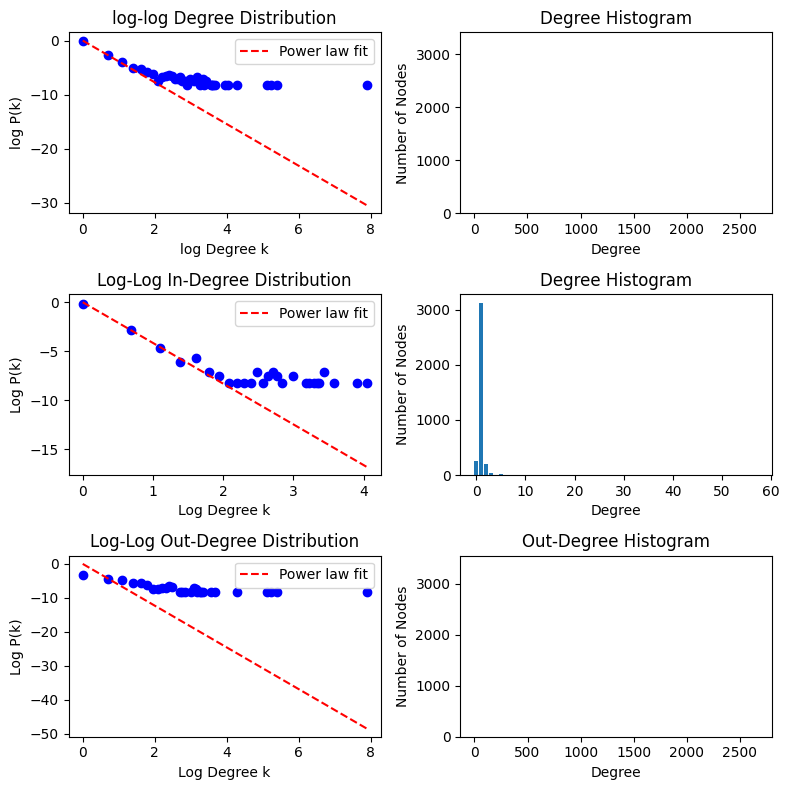

{'avg_clustering': 0.004792559098358698,
 'avg_degree': 2.3814684367380115,
 'degrees': array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   20,   22,   24,   25,
          26,   27,   28,   29,   31,   35,   36,   37,   39,   52,   57,
          73,  167,  190,  221, 2674]),
 'density': 0.00032269220010000153,
 'degree_proba': array([8.79707396e-01, 6.69195340e-02, 1.86941208e-02, 6.23137361e-03,
        4.87672717e-03, 3.25115145e-03, 1.89650501e-03, 5.41858575e-04,
        1.08371715e-03, 1.35464644e-03, 1.62557572e-03, 1.35464644e-03,
        8.12787862e-04, 8.12787862e-04, 1.08371715e-03, 5.41858575e-04,
        5.41858575e-04, 2.70929287e-04, 8.12787862e-04, 5.41858575e-04,
        1.08371715e-03, 5.41858575e-04, 2.70929287e-04, 5.41858575e-04,
        8.12787862e-04, 2.70929287e-04, 5.41858575e-04, 2.70929287e-04,
        2.70929287e-04, 2.70929287e-04, 2.70929287e-04, 2.70929287e-04,
        2.70929287e-04,

In [6]:
f.plot_degrees(g_athaliana, plot_fit=True)
properties_athaliana

Fitted power law parameter: b = -3.89


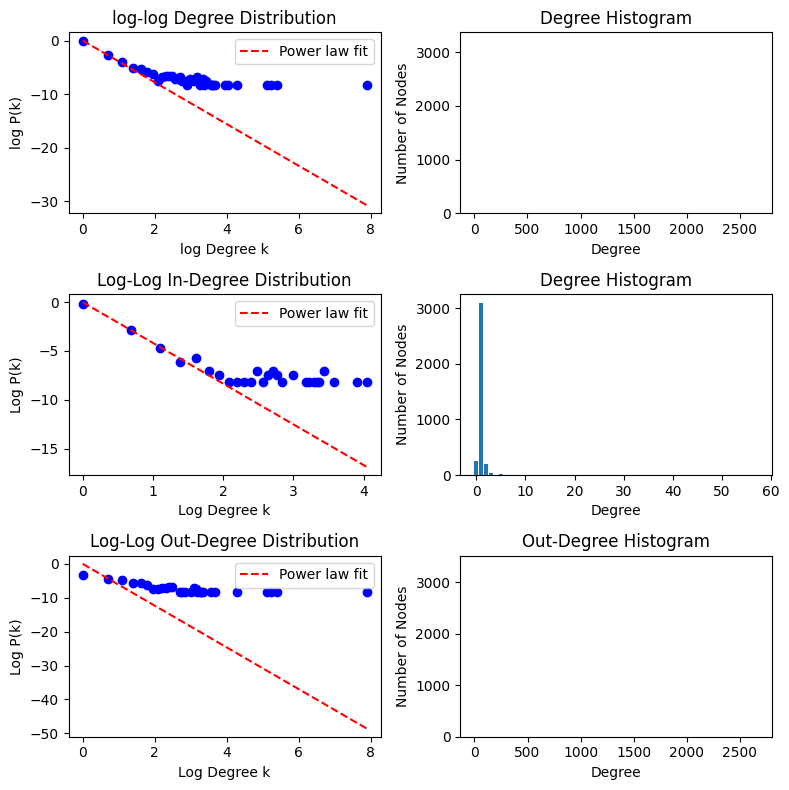

{'avg_clustering': 0.004861043042605648,
 'avg_degree': 2.3924154987633965,
 'degrees': array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   20,   22,   24,   25,
          26,   27,   28,   29,   31,   35,   36,   37,   39,   52,   57,
          73,  167,  190,  221, 2674]),
 'density': 0.00032880916695483733,
 'degree_proba': array([8.81835669e-01, 6.54025831e-02, 1.86864523e-02, 5.77081616e-03,
        4.94641385e-03, 3.02280846e-03, 1.92360539e-03, 5.49601539e-04,
        1.09920308e-03, 1.37400385e-03, 1.37400385e-03, 1.37400385e-03,
        8.24402308e-04, 8.24402308e-04, 1.09920308e-03, 5.49601539e-04,
        5.49601539e-04, 2.74800769e-04, 8.24402308e-04, 5.49601539e-04,
        1.09920308e-03, 5.49601539e-04, 2.74800769e-04, 5.49601539e-04,
        8.24402308e-04, 2.74800769e-04, 5.49601539e-04, 2.74800769e-04,
        2.74800769e-04, 2.74800769e-04, 2.74800769e-04, 2.74800769e-04,
        2.74800769e-04,

In [7]:
g_largest_athaliana = f.get_largest_cc(g_athaliana)
f.plot_degrees(g_largest_athaliana, plot_fit=True)
properties_largest_athaliana = gg.network_properties(g_largest_athaliana)
properties_largest_athaliana

Full degree power law exponent: 0.90
In-degree power law exponent: 1.58
Out-degree power law exponent: 0.63


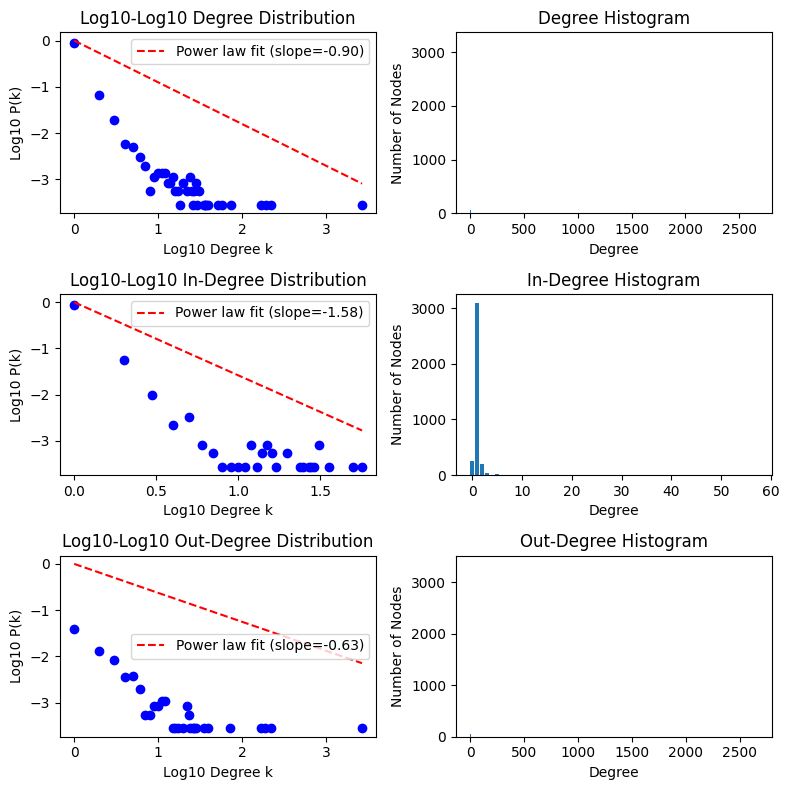

In [8]:
plot_degrees_log10(g_largest_athaliana, plot_fit=True)

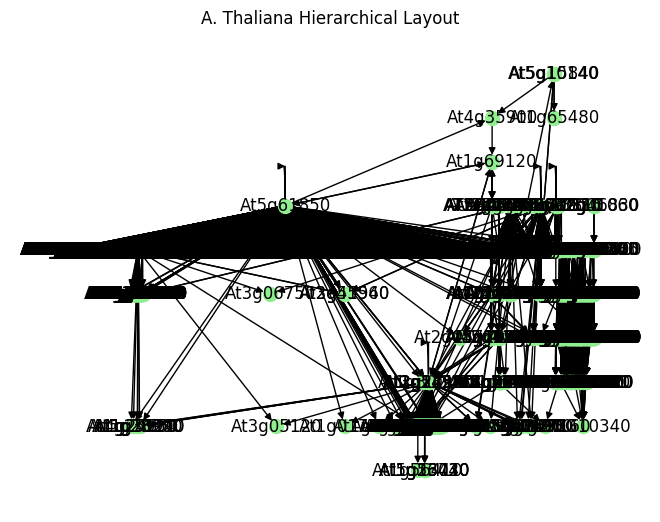

In [10]:
pos = graphviz_layout(g_largest_athaliana, prog='dot')  # Uses Graphviz's dot layout

nx.draw(g_largest_athaliana, pos, with_labels=True, arrows=True, node_color="lightgreen", node_size=100)
plt.title("A. Thaliana Hierarchical Layout")
plt.show()

## Drosophila Melanogaster

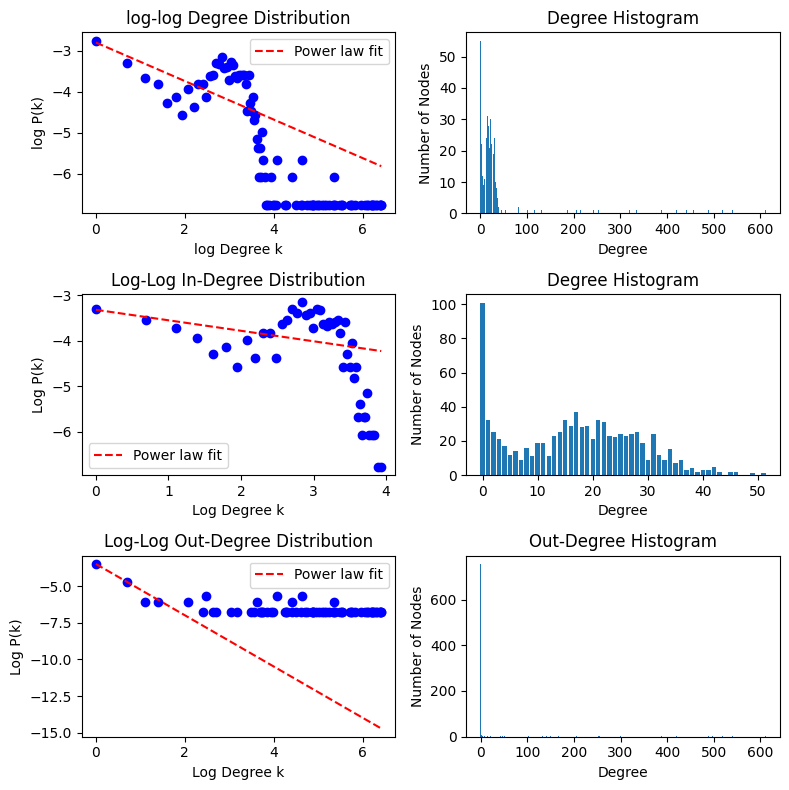

Fitted power law parameters: a = 0.03, b = -1.75


{'avg_clustering': 0.016035848109490807,
 'avg_degree': 33.03114186851211,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  45,  46,  47,  49,  51,  54,  55,  57,  59,
         70,  71,  82,  89, 101, 102, 103, 116, 124, 130, 131, 132, 133,
        141, 148, 150, 162, 167, 177, 187, 206, 209, 211, 215, 243, 253,
        255, 300, 310, 320, 335, 388, 420, 442, 457, 489, 497, 500, 509,
        519, 540, 558, 591, 599, 603, 611]),
 'density': 0.01907109807650815,
 'degree_proba': array([0.06343714, 0.03690888, 0.02537486, 0.02191465, 0.01384083,
        0.01614764, 0.01038062, 0.01960784, 0.01268743, 0.02191465,
        0.02191465, 0.01614764, 0.02652826, 0.02768166, 0.03690888,
        0.03575548, 0.04267589, 0.03229527, 0.03344867, 0.02422145,
        0.03806228, 0.03460208, 0.026

In [17]:
f.plot_degrees(g_dmelanogaster, plot_fit=True)
properties_dmelanogaster

Fitted power law parameter: b = -4.49


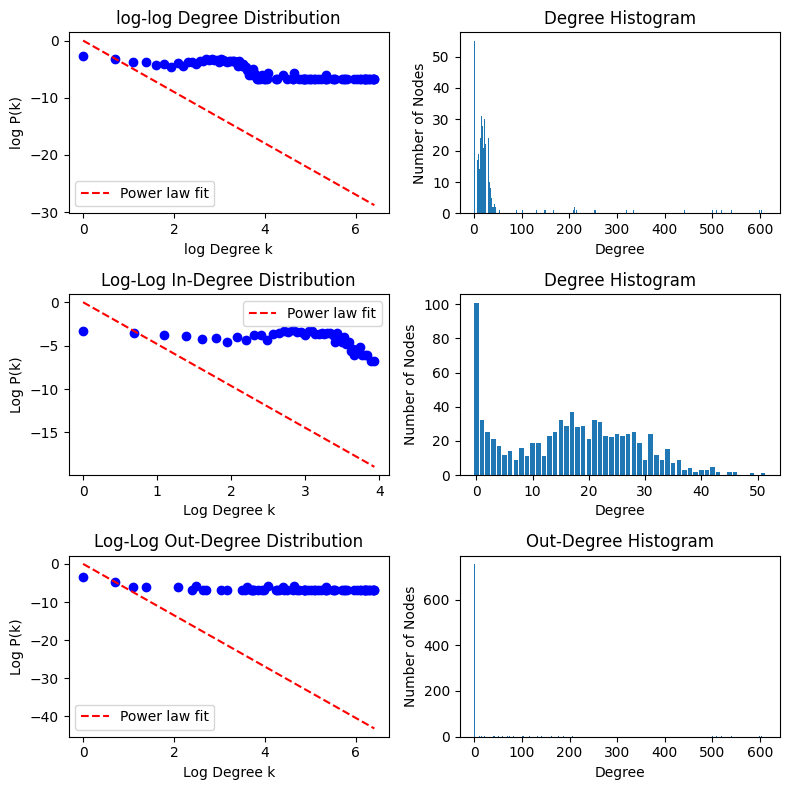

{'avg_clustering': 0.016035848109490807,
 'avg_degree': 33.03114186851211,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  45,  46,  47,  49,  51,  54,  55,  57,  59,
         70,  71,  82,  89, 101, 102, 103, 116, 124, 130, 131, 132, 133,
        141, 148, 150, 162, 167, 177, 187, 206, 209, 211, 215, 243, 253,
        255, 300, 310, 320, 335, 388, 420, 442, 457, 489, 497, 500, 509,
        519, 540, 558, 591, 599, 603, 611]),
 'density': 0.01907109807650815,
 'degree_proba': array([0.06343714, 0.03690888, 0.02537486, 0.02191465, 0.01384083,
        0.01614764, 0.01038062, 0.01960784, 0.01268743, 0.02191465,
        0.02191465, 0.01614764, 0.02652826, 0.02768166, 0.03690888,
        0.03575548, 0.04267589, 0.03229527, 0.03344867, 0.02422145,
        0.03806228, 0.03460208, 0.026

In [9]:
g_largest_dmelanogaster = f.get_largest_cc(g_dmelanogaster)
f.plot_degrees(g_largest_dmelanogaster, plot_fit=True)
properties_largest_dmelanogaster = gg.network_properties(g_largest_dmelanogaster)
properties_largest_dmelanogaster

Full degree power law exponent: 0.81
In-degree power law exponent: 0.59
Out-degree power law exponent: 0.22


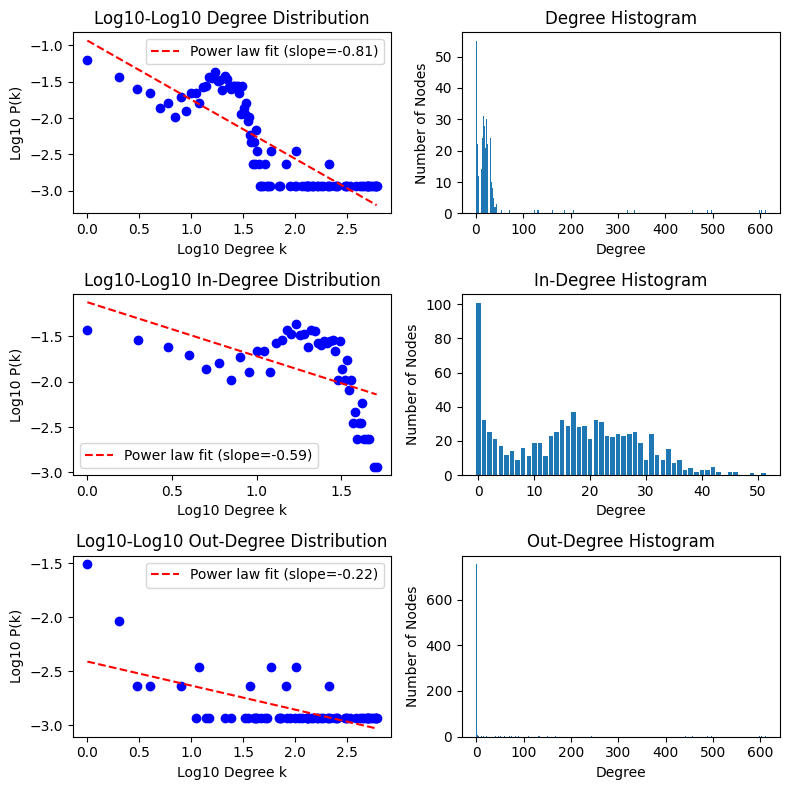

In [10]:
plot_degrees_log10(g_largest_dmelanogaster, plot_fit=True)

## Escherichia Coli

### Full network

Fitted power law parameter: b = -2.02


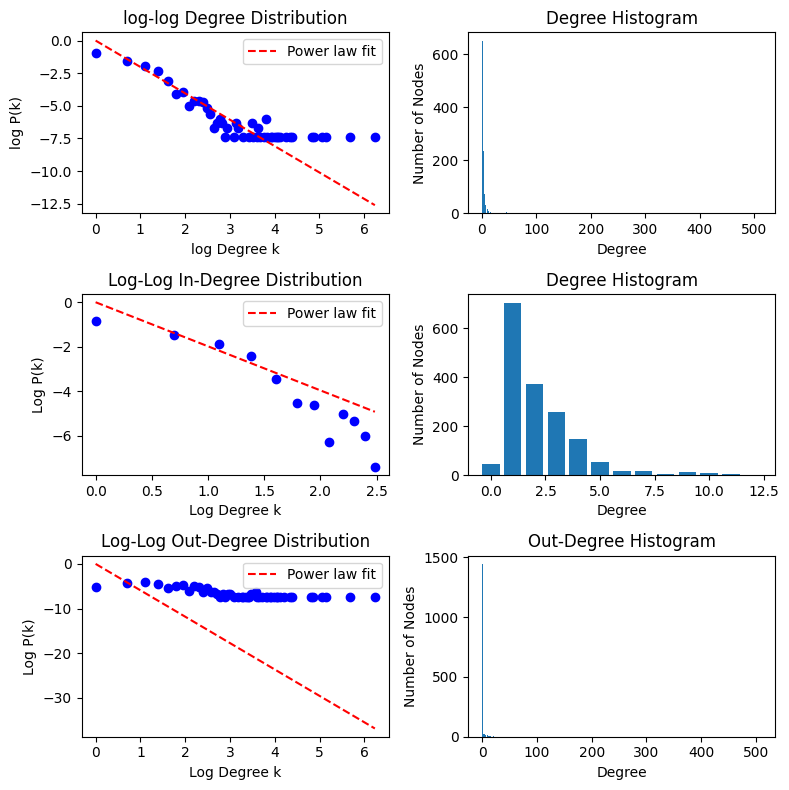

{'avg_clustering': 0.12683262146811017,
 'avg_degree': 4.3341463414634145,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  22,  23,  24,  27,  31,  33,  34,
         37,  38,  39,  43,  45,  46,  50,  52,  55,  58,  59,  62,  70,
         77,  80, 125, 132, 157, 173, 296, 513]),
 'density': 0.0013221922945281924,
 'degree_proba': array([0.39634146, 0.20792683, 0.14390244, 0.09634146, 0.04390244,
        0.01646341, 0.01890244, 0.00670732, 0.0097561 , 0.0097561 ,
        0.00914634, 0.0054878 , 0.00365854, 0.00121951, 0.00182927,
        0.00243902, 0.00182927, 0.00060976, 0.00121951, 0.00060976,
        0.00182927, 0.00121951, 0.00060976, 0.00060976, 0.00182927,
        0.00060976, 0.00060976, 0.00121951, 0.00060976, 0.00060976,
        0.00243902, 0.00060976, 0.00060976, 0.00060976, 0.00060976,
        0.00060976, 0.00060976, 0.00060976, 0.00060976, 0.00060976,
        0.00060976, 0.00060976, 0.00060976, 0.0006

In [4]:
f.plot_degrees(g_ecoli, plot_fit=True)
properties_ecoli

### Largest component

Fitted power law parameter: b = -1.97


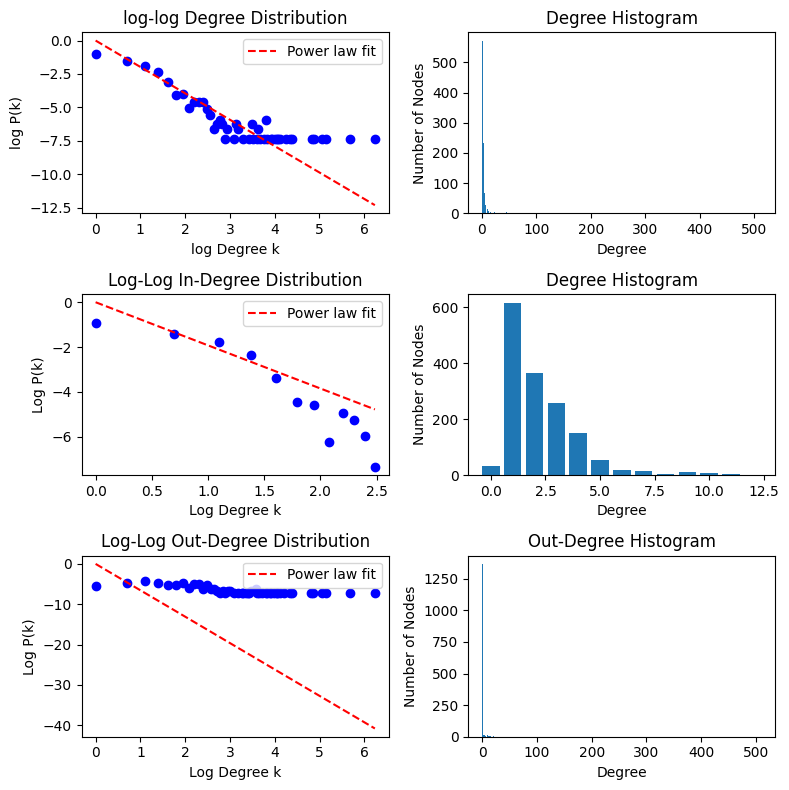

{'avg_clustering': 0.13446834151938689,
 'avg_degree': 4.506527415143603,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  22,  23,  24,  27,  31,  33,  34,
         37,  38,  39,  43,  45,  46,  50,  52,  55,  58,  59,  62,  70,
         77,  80, 125, 132, 157, 173, 296, 513]),
 'density': 0.0014717594432212943,
 'degree_proba': array([0.3727154 , 0.21932115, 0.15208877, 0.09530026, 0.04438642,
        0.01762402, 0.01827676, 0.00652742, 0.00979112, 0.01044386,
        0.00979112, 0.00587467, 0.00391645, 0.00130548, 0.00195822,
        0.00261097, 0.00195822, 0.00065274, 0.00130548, 0.00065274,
        0.00195822, 0.00130548, 0.00065274, 0.00065274, 0.00195822,
        0.00065274, 0.00065274, 0.00130548, 0.00065274, 0.00065274,
        0.00261097, 0.00065274, 0.00065274, 0.00065274, 0.00065274,
        0.00065274, 0.00065274, 0.00065274, 0.00065274, 0.00065274,
        0.00065274, 0.00065274, 0.00065274, 0.00065

In [16]:
g_largest_ecoli = f.get_largest_cc(g_ecoli)
f.plot_degrees(g_largest_ecoli, plot_fit=True)
properties_largest_ecoli = gg.network_properties(g_largest_ecoli)
properties_largest_ecoli

Full degree power law exponent: 1.20
In-degree power law exponent: 2.54
Out-degree power law exponent: 0.61


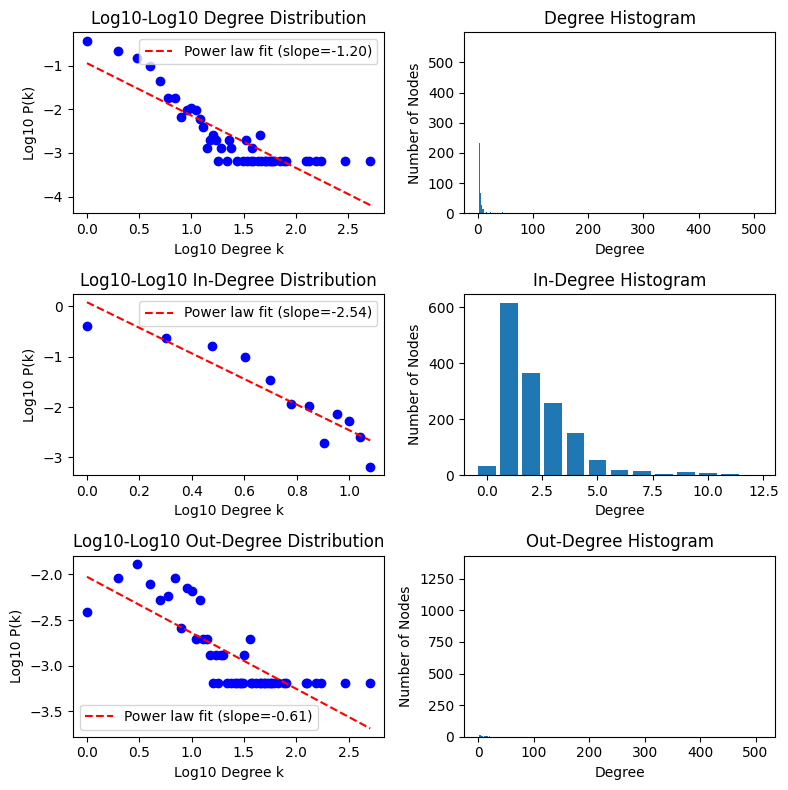

In [12]:
plot_degrees_log10(g_largest_ecoli, plot_fit=True)

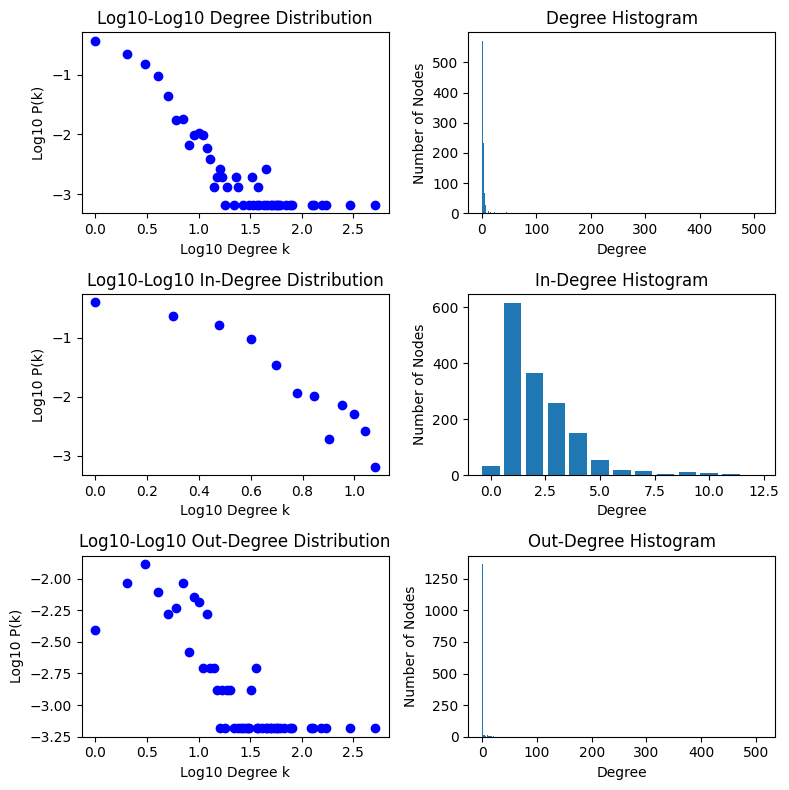

In [18]:
plot_degrees_log10(g_largest_ecoli, plot_fit=False)

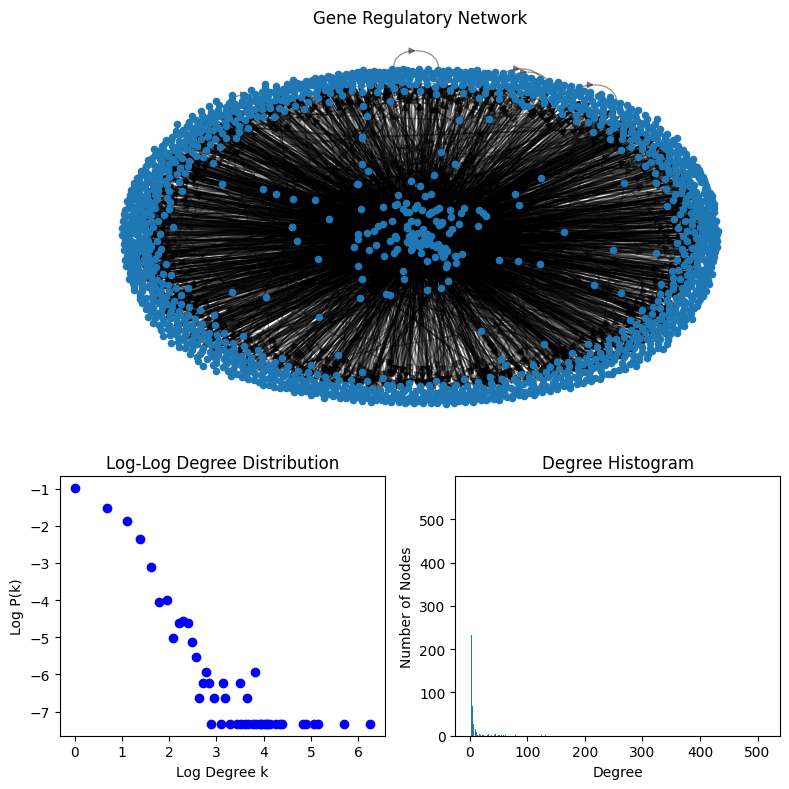

In [23]:
gg.plot_grn_degree(g_largest_ecoli, plot_network=True, layout='spring')

## Homo Sapiens

### Full network

Fitted power law parameter: b = -1.85


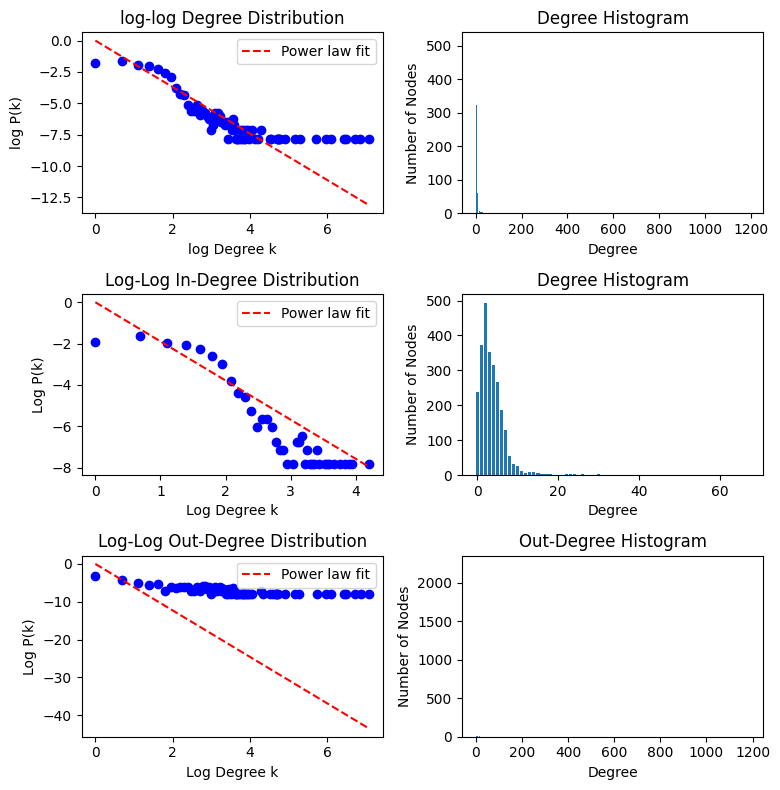

{'avg_clustering': 0.11254306246828757,
 'avg_degree': 7.5371316306483305,
 'degrees': array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   34,
          35,   36,   37,   38,   39,   40,   42,   43,   44,   46,   47,
          48,   49,   52,   54,   57,   63,   67,   72,   92,   94,  110,
         113,  114,  116,  118,  134,  176,  200,  306,  390,  448,  617,
         651,  830,  956, 1193]),
 'density': 0.0014813544871557253,
 'degree_proba': array([0.17131631, 0.20235756, 0.14145383, 0.12730845, 0.10569745,
        0.07308448, 0.05304519, 0.02357564, 0.01453831, 0.01257367,
        0.00589391, 0.00353635, 0.00353635, 0.00589391, 0.00275049,
        0.00392927, 0.00314342, 0.00235756, 0.00196464, 0.00078585,
        0.00117878, 0.00314342, 0.00196464, 0.00314342, 0.00235756,
        0.00157171, 0.00157171, 0.00157171, 0

In [6]:
f.plot_degrees(g_hsapiens, plot_fit=True)
properties_hsapiens

### Largest Component

Fitted power law parameter: b = -1.85


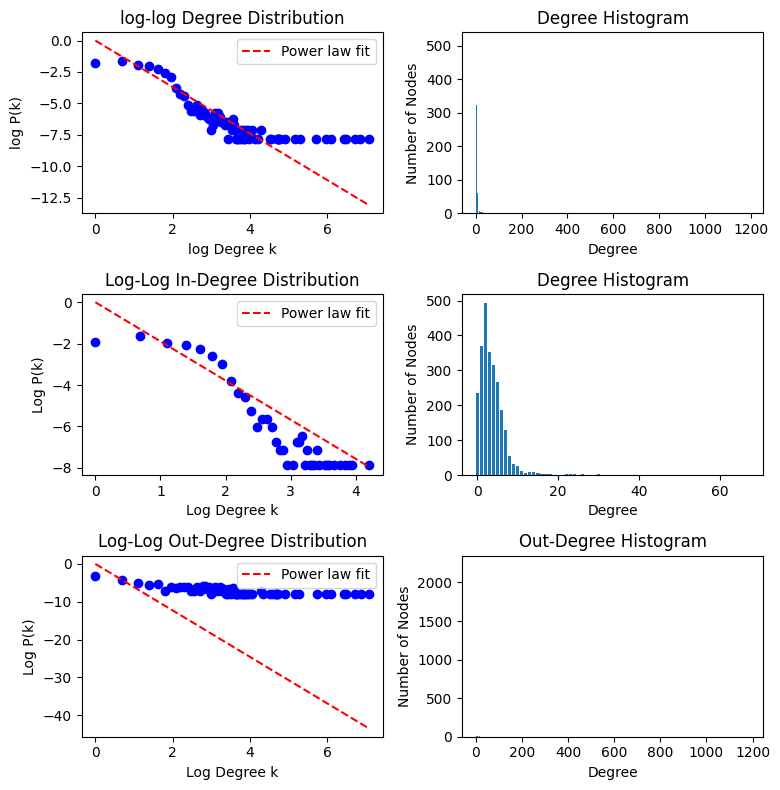

{'avg_clustering': 0.11280901692863012,
 'avg_degree': 7.552579755809374,
 'degrees': array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   34,
          35,   36,   37,   38,   39,   40,   42,   43,   44,   46,   47,
          48,   49,   52,   54,   57,   63,   67,   72,   92,   94,  110,
         113,  114,  116,  118,  134,  176,  200,  306,  390,  448,  617,
         651,  830,  956, 1193]),
 'density': 0.0014878998730908932,
 'degree_proba': array([0.16935801, 0.20283576, 0.14178811, 0.12760929, 0.10594722,
        0.07325719, 0.05317054, 0.02363135, 0.01457267, 0.01260339,
        0.00590784, 0.0035447 , 0.0035447 , 0.00590784, 0.00275699,
        0.00393856, 0.00315085, 0.00236314, 0.00196928, 0.00078771,
        0.00118157, 0.00315085, 0.00196928, 0.00315085, 0.00236314,
        0.00157542, 0.00157542, 0.00157542, 0.

In [11]:
g_largest_hsapiens = f.get_largest_cc(g_hsapiens)
f.plot_degrees(g_largest_hsapiens, plot_fit=True)
properties_largest_hsapiens = gg.network_properties(g_largest_hsapiens)
properties_largest_hsapiens

Full degree power law exponent: 1.02
In-degree power law exponent: 2.13
Out-degree power law exponent: 0.51


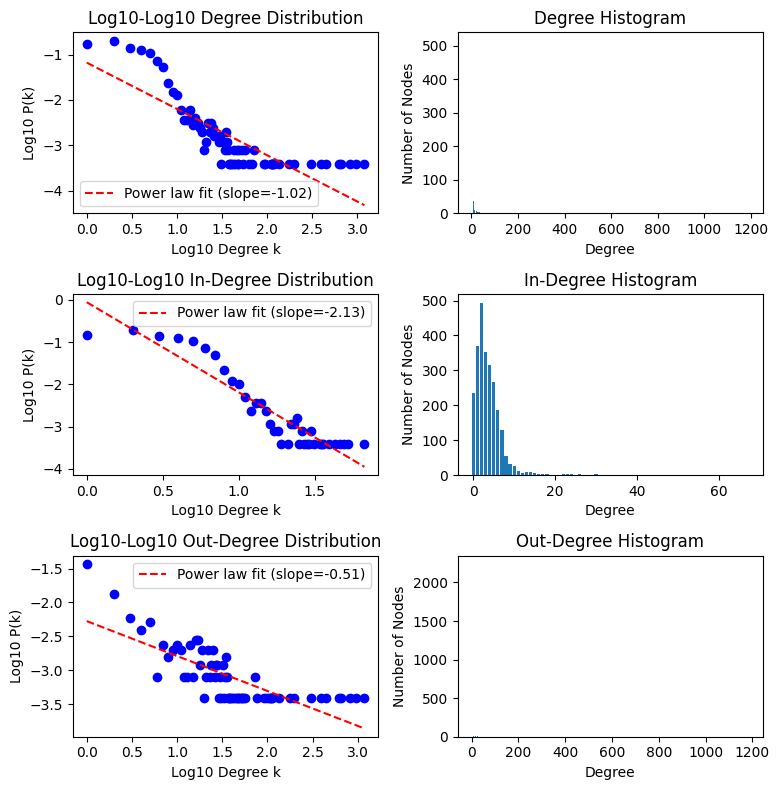

In [14]:
plot_degrees_log10(g_largest_hsapiens, plot_fit=True)

Full degree power law exponent: 1.02
In-degree power law exponent: 2.13
Out-degree power law exponent: 0.51


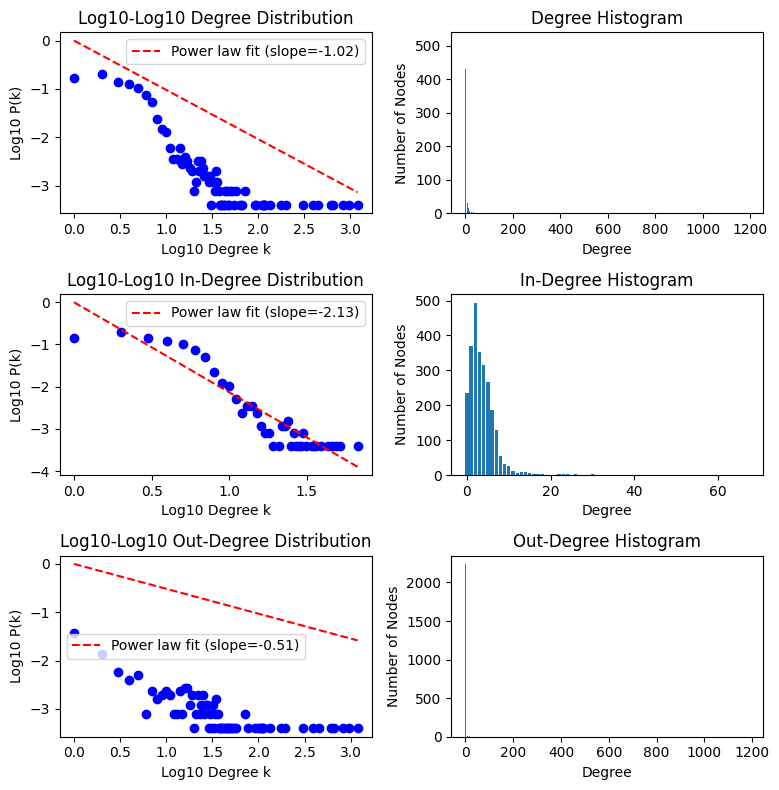

In [16]:
# With no intercept
plot_degrees_log10(g_largest_hsapiens, plot_fit=True)

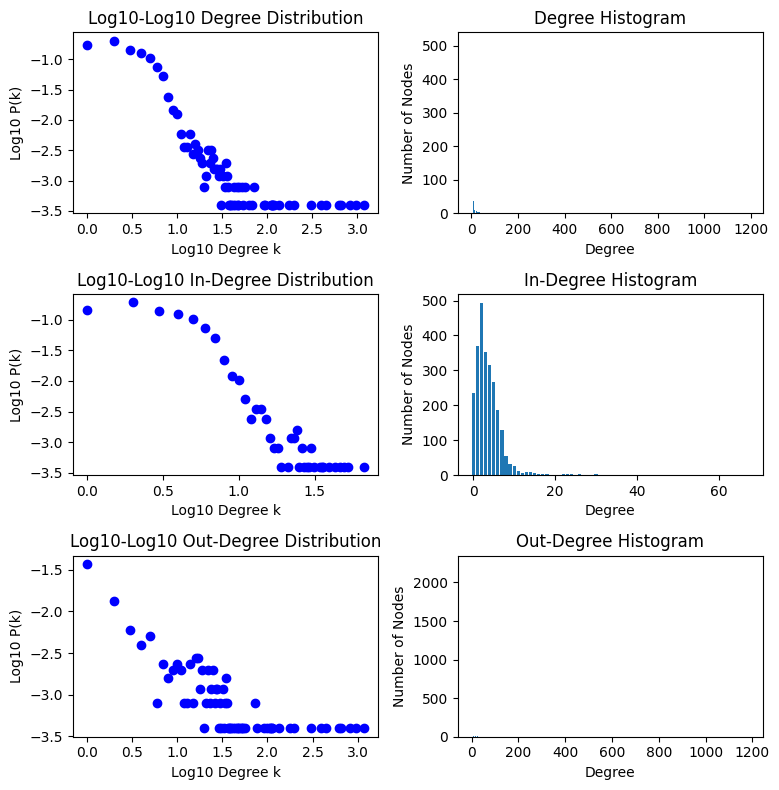

In [17]:
plot_degrees_log10(g_largest_hsapiens, plot_fit=False)

In [13]:
pos = graphviz_layout(g_largest_hsapiens, prog='dot')  # Uses Graphviz's dot layout

nx.draw(g_largest_hsapiens, pos, with_labels=False, arrows=True, node_color="lightgreen", node_size=10, arrowsize=5)
plt.title("H. Sapiens Hierarchical Layout")
plt.show()

KeyboardInterrupt: 

In [14]:
# nx.write_graphml(g_largest_hsapiens, "hsapiens.graphml")

In [15]:
# Edges
edges_df = nx.to_pandas_edgelist(g_largest_hsapiens)
edges_df.to_csv("hsapiens_edges.csv", index=False)

# Nodes
nodes_df = pd.DataFrame(g_largest_hsapiens.nodes(), columns=["id"])
nodes_df.to_csv("hsapiens_nodes.csv", index=False)

## Saccharomyces Cerevisiae

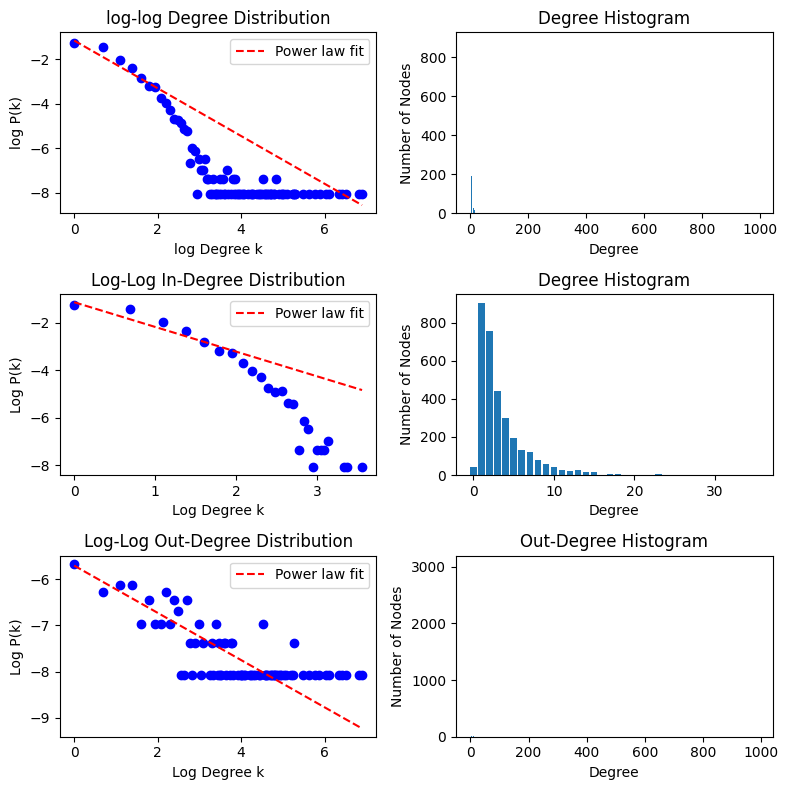

Fitted power law parameters: a = 0.00, b = -0.51


{'avg_clustering': 0.17515575541285128,
 'avg_degree': 6.859918520839862,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  40,
         43,  45,  46,  47,  48,  51,  52,  55,  57,  59,  65,  69,  71,
         72,  80,  84,  86,  90,  93,  96,  97, 101, 103, 108, 111, 112,
        119, 121, 125, 135, 144, 147, 153, 164, 188, 189, 198, 199, 242,
        280, 324, 359, 416, 447, 566, 608, 683, 930, 992]),
 'density': 0.0010752223386896337,
 'degree_proba': array([0.27702914, 0.23190223, 0.13162018, 0.09119398, 0.05954246,
        0.04136634, 0.03823253, 0.02381699, 0.01911626, 0.01410216,
        0.00908806, 0.00877468, 0.00783453, 0.00595425, 0.00532748,
        0.00125353, 0.00250705, 0.00219367, 0.00031338, 0.00156691,
        0.00094014, 0.00094014, 0.00156691, 0.00062676, 0.00062676,
        0.00031338, 0.0003

In [23]:
f.plot_degrees(g_scerevisiae, plot_fit=True)
properties_scerevisiae

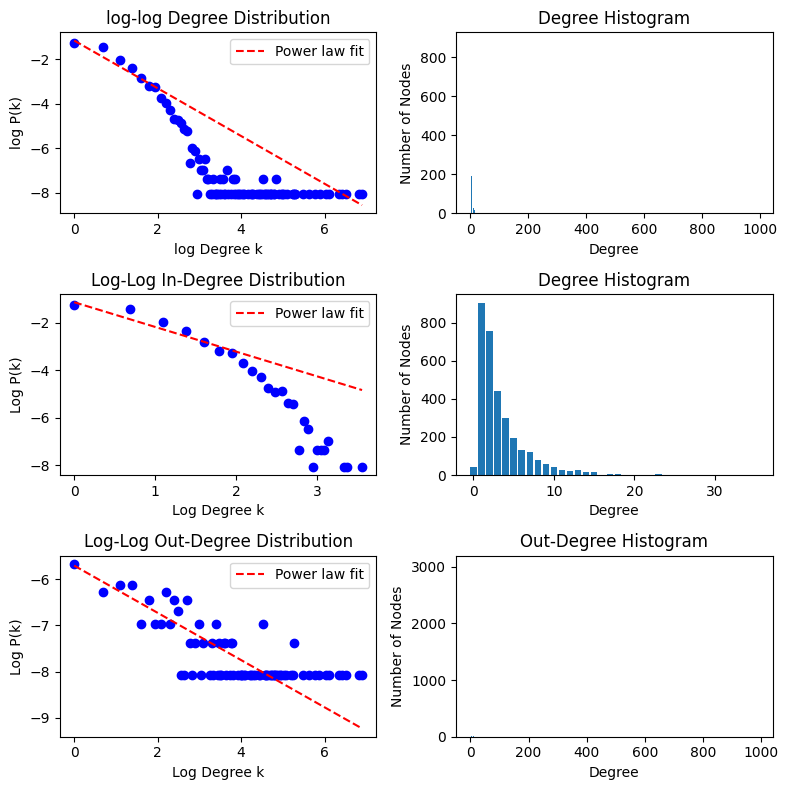

Fitted power law parameters: a = 0.00, b = -0.51


{'avg_clustering': 0.17515575541285128,
 'avg_degree': 6.859918520839862,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  40,
         43,  45,  46,  47,  48,  51,  52,  55,  57,  59,  65,  69,  71,
         72,  80,  84,  86,  90,  93,  96,  97, 101, 103, 108, 111, 112,
        119, 121, 125, 135, 144, 147, 153, 164, 188, 189, 198, 199, 242,
        280, 324, 359, 416, 447, 566, 608, 683, 930, 992]),
 'density': 0.0010752223386896337,
 'degree_proba': array([0.27702914, 0.23190223, 0.13162018, 0.09119398, 0.05954246,
        0.04136634, 0.03823253, 0.02381699, 0.01911626, 0.01410216,
        0.00908806, 0.00877468, 0.00783453, 0.00595425, 0.00532748,
        0.00125353, 0.00250705, 0.00219367, 0.00031338, 0.00156691,
        0.00094014, 0.00094014, 0.00156691, 0.00062676, 0.00062676,
        0.00031338, 0.0003

In [24]:
g_largest_scerevisiae = f.get_largest_cc(g_scerevisiae)
f.plot_degrees(g_largest_scerevisiae, plot_fit=True)
properties_largest_scerevisiae = gg.network_properties(g_largest_scerevisiae)
properties_largest_scerevisiae

# Network comparison

# GNW Ecoli VS Homo Sapiens

In [41]:
filepath = '../data/gnw/Ecoli-full.tsv'
adj_mx = gg.adj_mx_gnw_goldstandard(filepath)
ecoli_grn = nx.from_numpy_array(adj_mx, create_using=nx.DiGraph())

# Get the largest weakly connected component
largest_weakly_cc = max(nx.weakly_connected_components(ecoli_grn), key=len)

# Create the subgraph
ecoli_largest = ecoli_grn.subgraph(largest_weakly_cc).copy()
largest_gnw_properties = gg.network_properties(ecoli_largest)

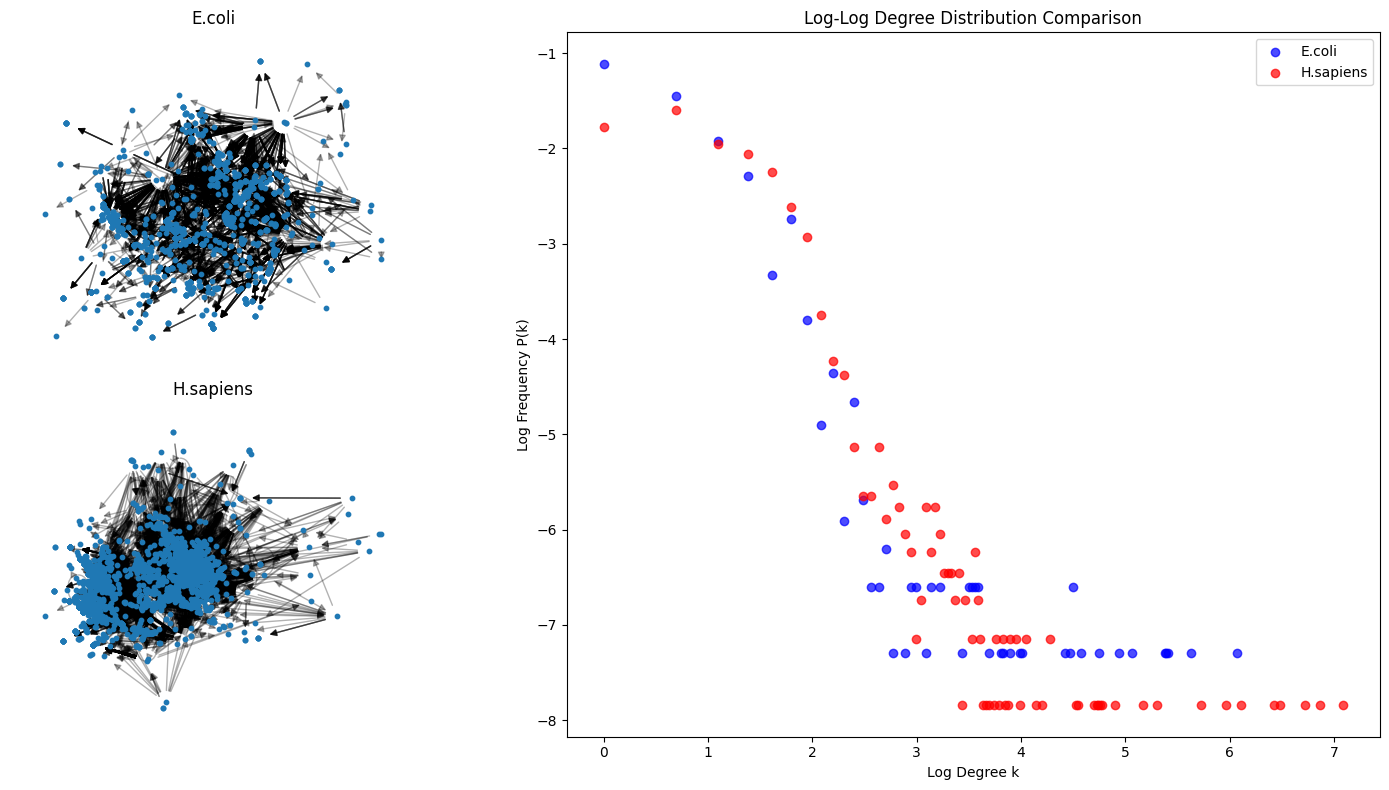

In [43]:
gg.plot_degree_network(ecoli_largest,human_largest, 'E.coli', 'H.sapiens')

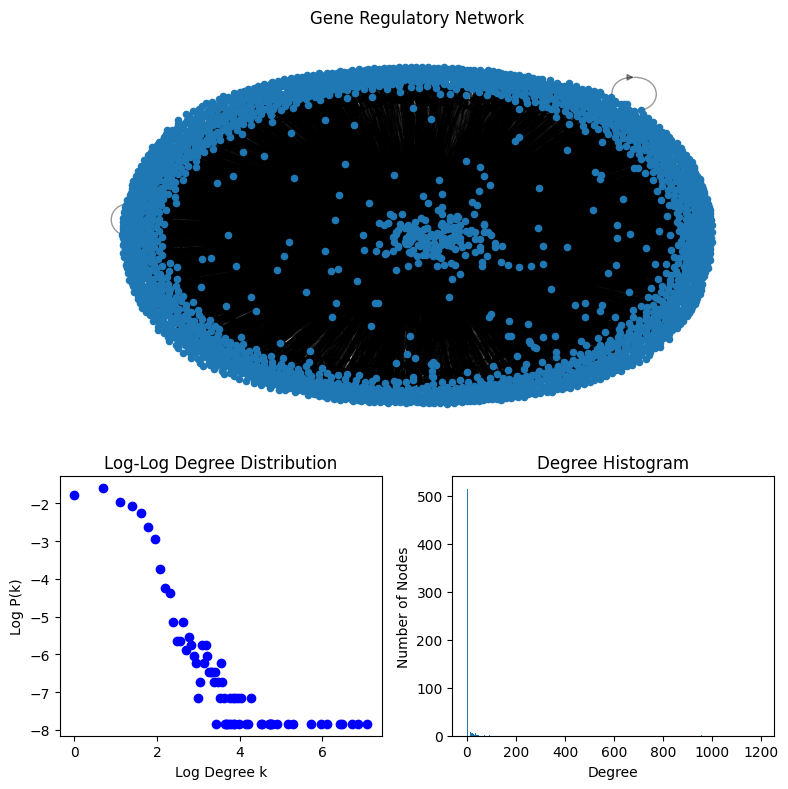

In [22]:
gg.plot_grn_degree(g_largest_hsapiens, plot_network=True, layout='spring')

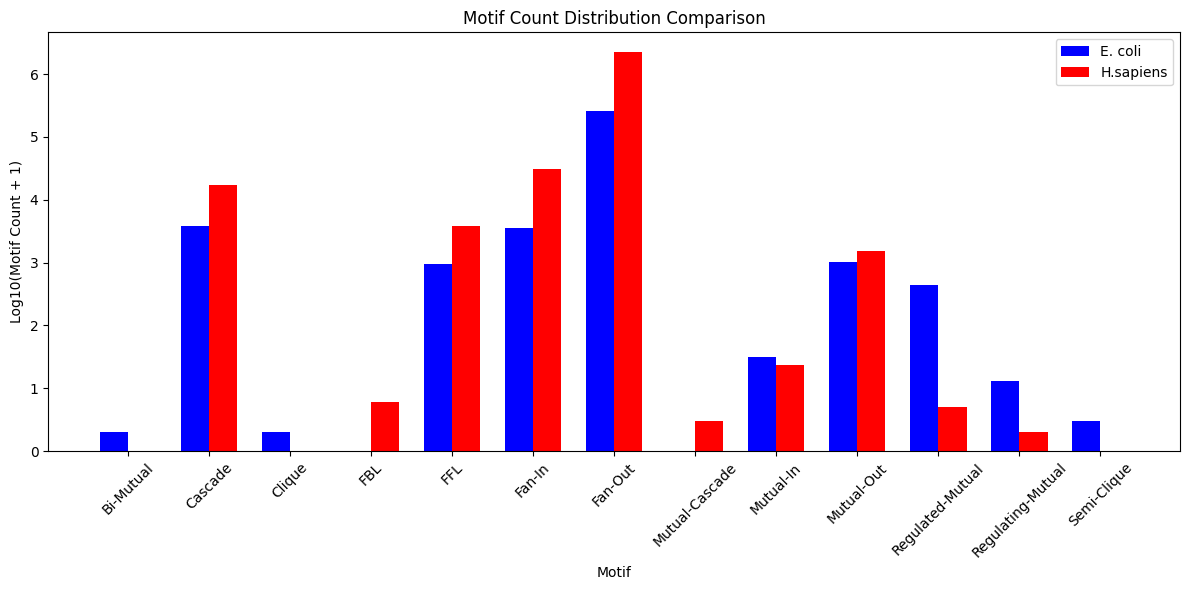

In [56]:
gg.compare_motif_dist(ecoli_largest, human_largest, "E. coli", "H.sapiens")#, save_filename='motif_distribution.eps')

# Paper E Coli VS Homo Sapiens

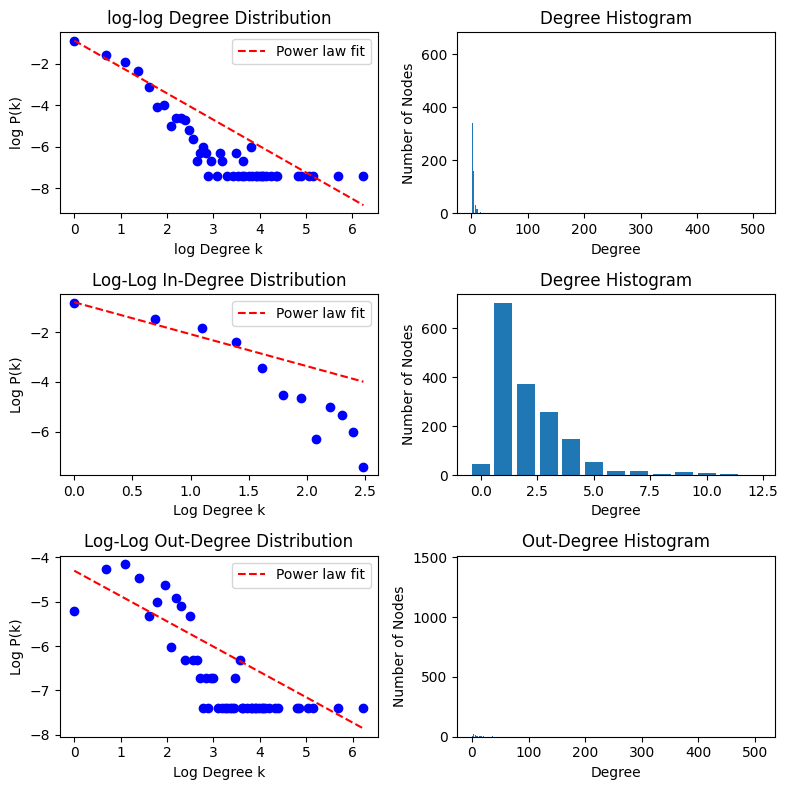

Fitted power law parameters: a = 0.01, b = -0.57


{'avg_clustering': 0.12683262146811017,
 'avg_degree': 4.3341463414634145,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  22,  23,  24,  27,  31,  33,  34,
         37,  38,  39,  43,  45,  46,  50,  52,  55,  58,  59,  62,  70,
         77,  80, 125, 132, 157, 173, 296, 513]),
 'density': 0.0013221922945281924,
 'degree_proba': array([0.39634146, 0.20792683, 0.14390244, 0.09634146, 0.04390244,
        0.01646341, 0.01890244, 0.00670732, 0.0097561 , 0.0097561 ,
        0.00914634, 0.0054878 , 0.00365854, 0.00121951, 0.00182927,
        0.00243902, 0.00182927, 0.00060976, 0.00121951, 0.00060976,
        0.00182927, 0.00121951, 0.00060976, 0.00060976, 0.00182927,
        0.00060976, 0.00060976, 0.00121951, 0.00060976, 0.00060976,
        0.00243902, 0.00060976, 0.00060976, 0.00060976, 0.00060976,
        0.00060976, 0.00060976, 0.00060976, 0.00060976, 0.00060976,
        0.00060976, 0.00060976, 0.00060976, 0.0006

In [44]:
g_ecoli = create_graph(escherichniaColi)
ecoli_properties = gg.network_properties(g_ecoli)
plot_degrees(g_ecoli, plot_fit=True)
ecoli_properties

In [52]:
# Get the largest weakly connected component
largest_ecoli_paper_weakly_cc = max(nx.weakly_connected_components(g_ecoli), key=len)
ecoli_paper_largest = g_ecoli.subgraph(largest_ecoli_paper_weakly_cc).copy()

In [57]:
ecoli_paper_largest_properties = gg.network_properties(ecoli_paper_largest)

In [58]:
ecoli_paper_largest_properties

{'avg_clustering': 0.13446834151938689,
 'avg_degree': 4.506527415143603,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  22,  23,  24,  27,  31,  33,  34,
         37,  38,  39,  43,  45,  46,  50,  52,  55,  58,  59,  62,  70,
         77,  80, 125, 132, 157, 173, 296, 513]),
 'density': 0.0014717594432212943,
 'degree_proba': array([0.3727154 , 0.21932115, 0.15208877, 0.09530026, 0.04438642,
        0.01762402, 0.01827676, 0.00652742, 0.00979112, 0.01044386,
        0.00979112, 0.00587467, 0.00391645, 0.00130548, 0.00195822,
        0.00261097, 0.00195822, 0.00065274, 0.00130548, 0.00065274,
        0.00195822, 0.00130548, 0.00065274, 0.00065274, 0.00195822,
        0.00065274, 0.00065274, 0.00130548, 0.00065274, 0.00065274,
        0.00261097, 0.00065274, 0.00065274, 0.00065274, 0.00065274,
        0.00065274, 0.00065274, 0.00065274, 0.00065274, 0.00065274,
        0.00065274, 0.00065274, 0.00065274, 0.00065

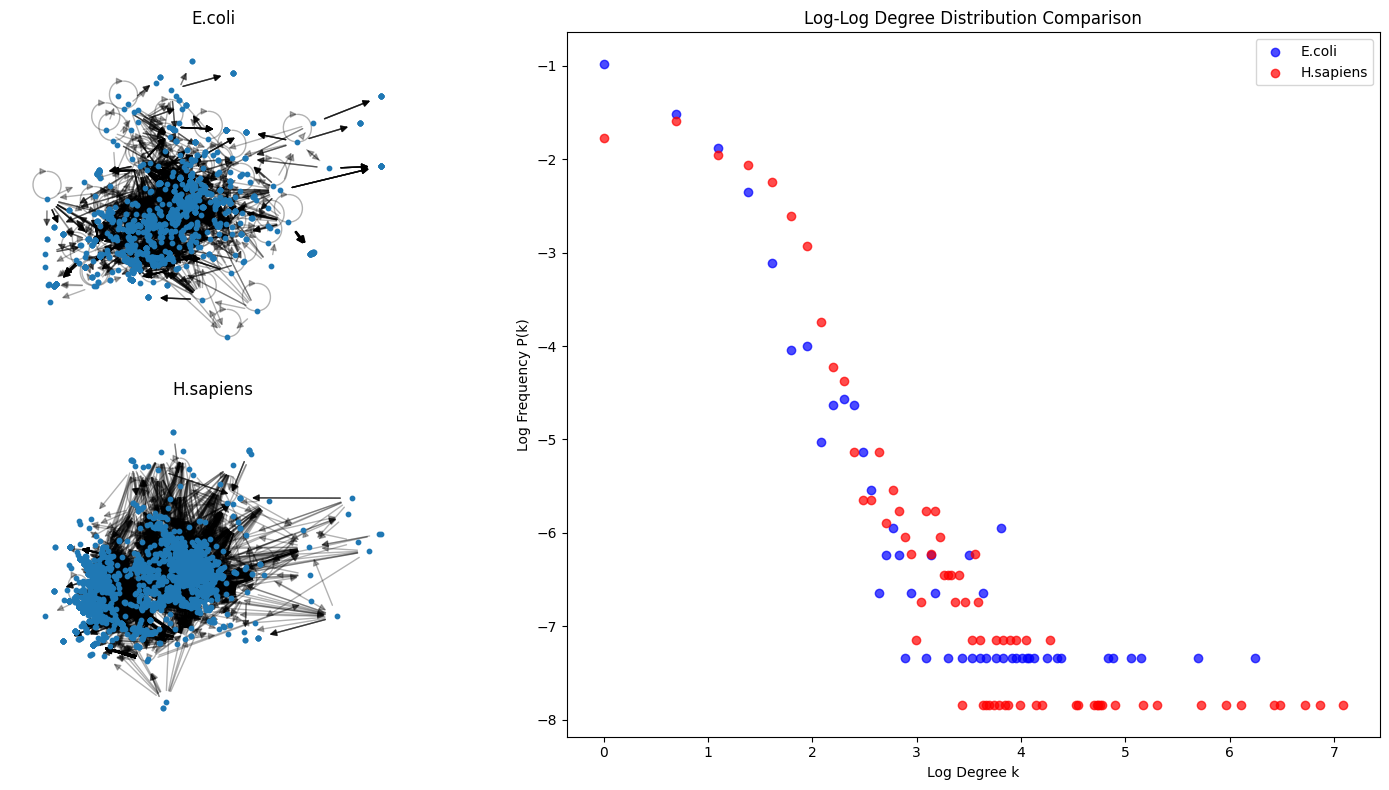

In [55]:
gg.plot_degree_network(ecoli_paper_largest,human_largest, 'E.coli', 'H.sapiens')

# TTRUST

The loaded data is from the paper https://www.nature.com/articles/srep11432#article-info and the data can be found on
https://www.grnpedia.org/trrust/downloadnetwork.php.

The data were downloaded the 02/07/2025.

In [5]:
filepath = "../data/gt_networks/trrust_rawdata.human.tsv"
ttrust = pd.read_csv(filepath,sep='\t',header=None,names=['TF','Target','Edge Type','Unknown'])

In [6]:
ttrust_clean = ttrust[ttrust['Edge Type'] != 'Unknown']

In [7]:
g_ttrust = nx.from_pandas_edgelist(ttrust_clean,source='TF', target='Target', create_using=nx.DiGraph(), edge_attr=True)

Fitted power law parameter: b = -2.18


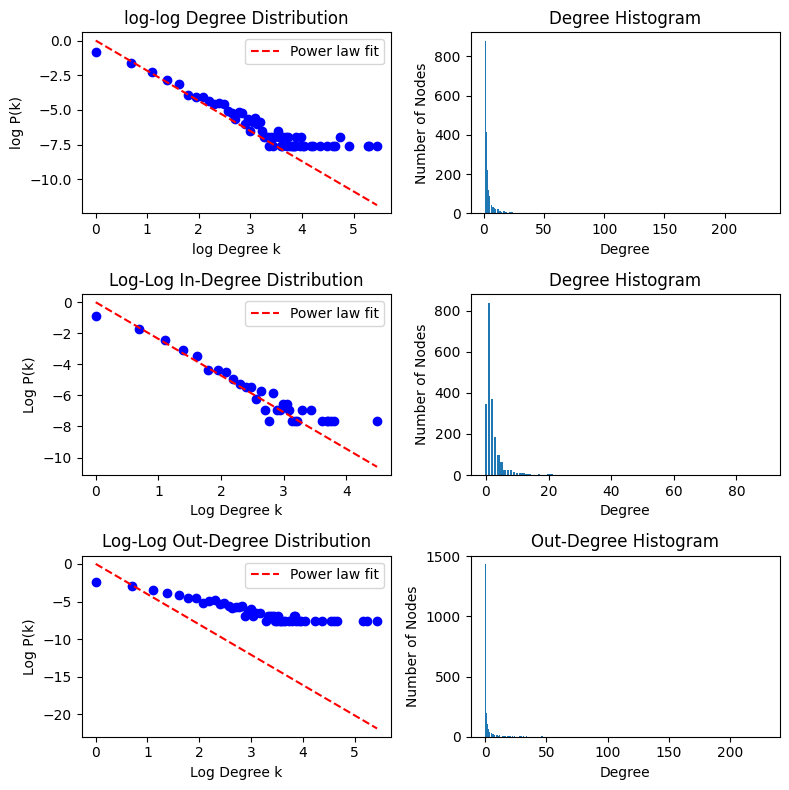

{'avg_clustering': 0.04494873107836058,
 'avg_degree': 4.69015444015444,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  34,  35,  36,  37,  38,  40,  41,
         42,  43,  45,  46,  47,  48,  49,  53,  54,  56,  57,  65,  67,
         78,  89,  99, 104, 114, 137, 198, 201, 234]),
 'density': 0.0011323405215244906,
 'degree_proba': array([0.4242278 , 0.19980695, 0.10569498, 0.05839768, 0.04295367,
        0.02027027, 0.01689189, 0.01689189, 0.01254826, 0.01013514,
        0.01110039, 0.01013514, 0.00627413, 0.00530888, 0.00337838,
        0.00579151, 0.00530888, 0.00241313, 0.00337838, 0.00144788,
        0.00289575, 0.003861  , 0.00241313, 0.00289575, 0.00144788,
        0.00096525, 0.00096525, 0.00096525, 0.00048263, 0.00096525,
        0.00048263, 0.00096525, 0.00144788, 0.00096525, 0.00048263,
        0.00048263, 0.00096525, 0.00096525

In [34]:
properties_ttrust = gg.network_properties(g_ttrust)
f.plot_degrees(g_ttrust, plot_fit=True)
properties_ttrust

Fitted power law parameter: b = -2.18


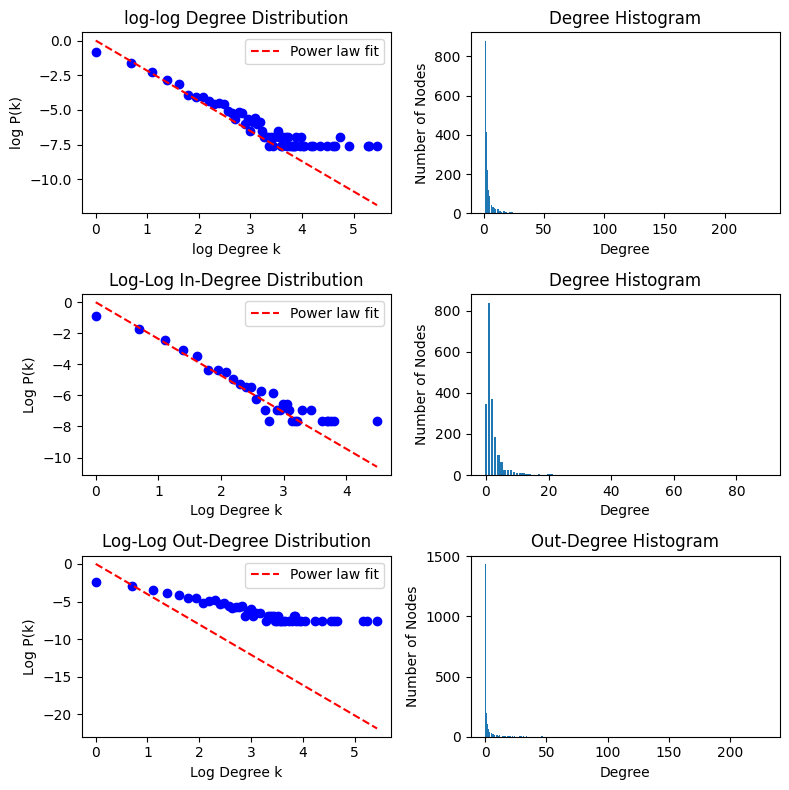

{'avg_clustering': 0.046289150494216266,
 'avg_degree': 4.798210735586481,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  34,  35,  36,  37,  38,  40,  41,
         42,  43,  45,  46,  47,  48,  49,  53,  54,  56,  57,  65,  67,
         78,  89,  99, 104, 114, 137, 198, 201, 234]),
 'density': 0.0011929912321199604,
 'degree_proba': array([0.40904573, 0.20377734, 0.10884692, 0.06013917, 0.04423459,
        0.02087475, 0.01739563, 0.01739563, 0.01292247, 0.01043738,
        0.01143141, 0.01043738, 0.00646123, 0.0054672 , 0.00347913,
        0.00596421, 0.0054672 , 0.00248509, 0.00347913, 0.00149105,
        0.00298211, 0.00397614, 0.00248509, 0.00298211, 0.00149105,
        0.00099404, 0.00099404, 0.00099404, 0.00049702, 0.00099404,
        0.00049702, 0.00099404, 0.00149105, 0.00099404, 0.00049702,
        0.00049702, 0.00099404, 0.000994

In [8]:
g_largest_ttrust = f.get_largest_cc(g_ttrust)
f.plot_degrees(g_ttrust, plot_fit=True)
properties_largest_ttrustttrust = gg.network_properties(g_largest_ttrust)
properties_largest_ttrustttrust

In [9]:
# nx.write_graphml(g_largest_ttrust, "trrust.graphml")

In [11]:
# Edges
edges_df = nx.to_pandas_edgelist(g_largest_ttrust)
edges_df.to_csv("hsapiens_trrust_edges.csv", index=False)

# Nodes
nodes_df = pd.DataFrame(g_largest_ttrust.nodes(), columns=["id"])
nodes_df.to_csv("hsapiens_trrus_nodes.csv", index=False)

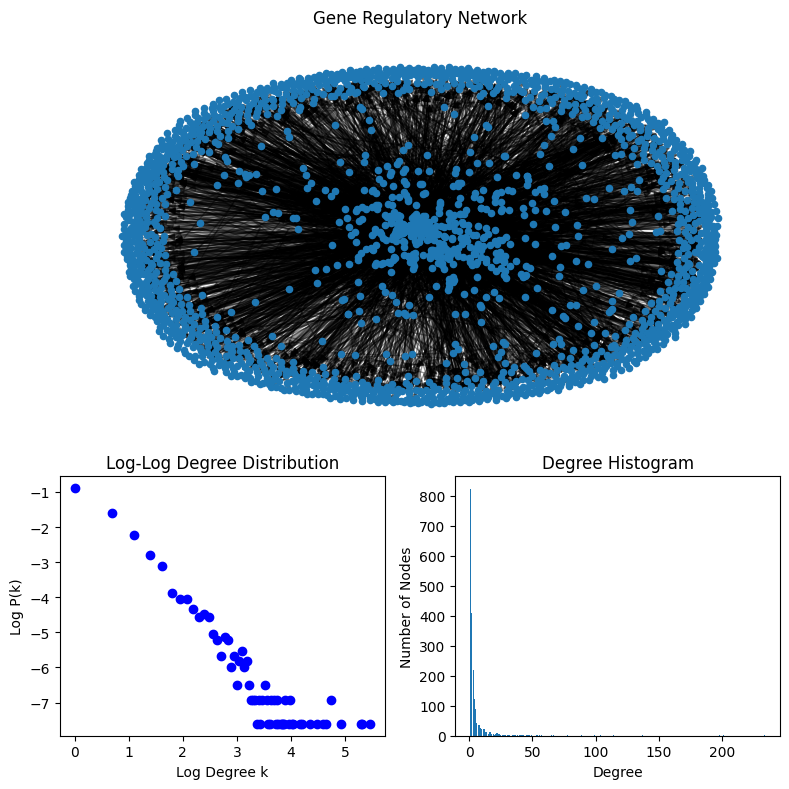

In [10]:
gg.plot_grn_degree(g_largest_ttrust, plot_network=True, layout='spring')

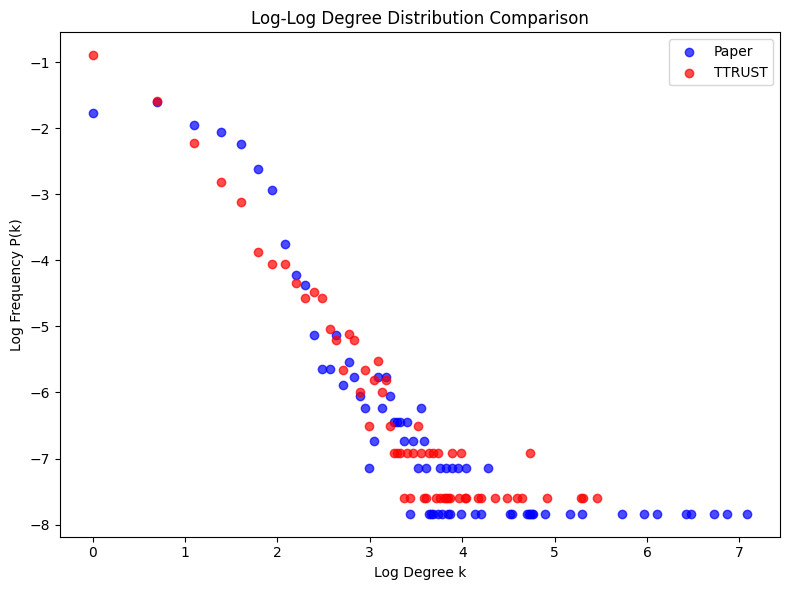

In [43]:
gg.compare_degree_distribution(g_largest_hsapiens,g_largest_ttrust, 'Paper', 'TTRUST')

# RegNetworks

In [24]:
filepath = "../data/gt_networks/human.source"
regnetwork = pd.read_csv(filepath, sep='\t', names=['TF Name', 'TF ID','Target', 'Target ID'], header = None)

/var/tmp/ipykernel_15086/3631520400.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  regnetwork = pd.read_csv(filepath, sep='\t', names=['TF Name', 'TF ID','Target', 'Target ID'], header = None)


In [25]:
regnetwork

TF Name      TF ID  Target Target ID
0               USF1       7391  S100A6      6277
1               USF1       7391   DUSP1      1843
2               USF1       7391     C4A       720
3               USF1       7391   ABCA1        19
4               TP53       7157    TP73      7161
...              ...        ...     ...       ...
372769    hsa-mir-31  MI0000089     RDX      5962
372770    hsa-mir-31  MI0000089    RHOA       387
372771   hsa-mir-328  MI0000804   ABCG2      9429
372772   hsa-mir-328  MI0000804    CD44       960
372773  hsa-mir-520c  MI0003158    CD44       960

[372774 rows x 4 columns]

In [26]:
g_regnetwork = nx.from_pandas_edgelist(regnetwork,source='TF Name', target='Target', create_using=nx.DiGraph(), edge_attr=None)

In [ ]:
gg.plot_grn_degree(g_regnetwork, plot_network=True, layout='spring')

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f468b1c52d0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [64]:
g_regnetwork.number_of_nodes()

23336

In [65]:
g_regnetwork.number_of_edges()

371517

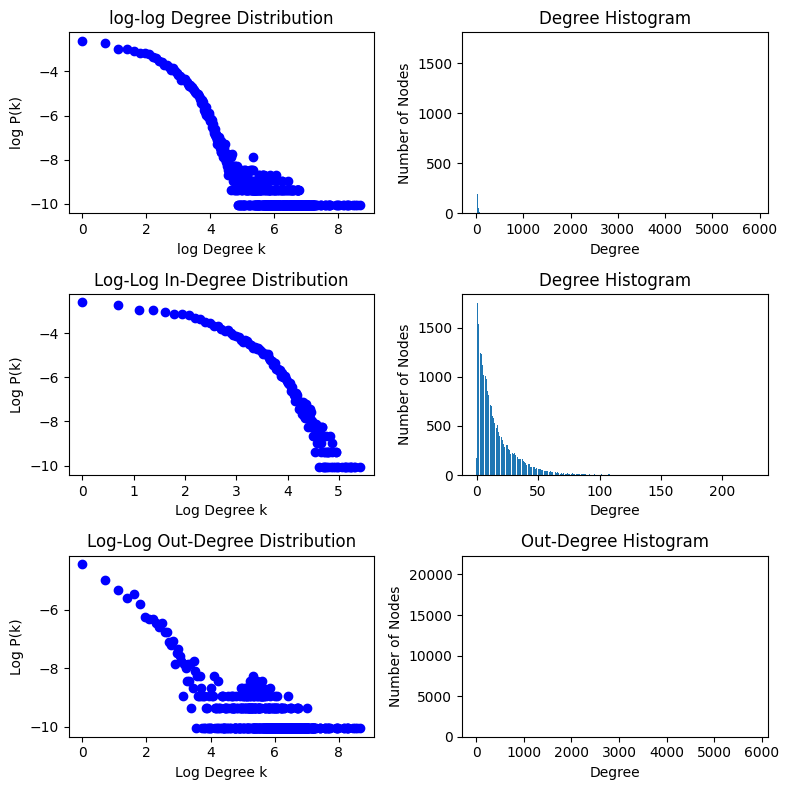

In [67]:
f.plot_degrees(g_regnetwork, plot_fit=False)

In [69]:
def network_properties(G):
    """
    Compute properties of a directed network.

    Parameters
    ----------
    G : nx.DiGraph
        A directed graph (NetworkX DiGraph).

    Returns
    -------
    dict
        A dictionary containing:
        
        - 'avg_clustering' : float
            Average clustering coefficient of the network.
        
        - 'avg_degree' : float
            Average degree of nodes in the network.
        
        - 'degrees' : np.ndarray
            Array of unique degrees in the network.
        
        - 'density' : float
            Density of the network.
        
        - 'degree_proba' : np.ndarray
            Probability distribution of node degrees (degree frequencies normalized by number of nodes).
        
        - 'modularity_value' : float or None
            Modularity of the network (based on the undirected version). None if computation fails.
        
        - 'nb_edges' : int
            Total number of edges in the network.
        
        - 'nb_nodes' : int
            Total number of nodes in the network.
        
        - 'strongly_connected' : bool
            Whether the network is strongly connected (every node reachable from every other, considering direction).
        
        - 'weakly_connected' : bool
            Whether the network is weakly connected (every node reachable from every other, ignoring direction).
    """
    res = {}
    
    # Degree distribution
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    N = G.number_of_nodes()
    degree_counts = np.unique(degree_sequence, return_counts=True)
    degrees = degree_counts[0]
    counts = degree_counts[1]
    degree_probabilities = counts / N

    # modularity_value = None  # Initialize to None in case of failure
    # try:
    #     communities = greedy_modularity_communities(G.to_undirected())
    #     modularity_value = modularity(G.to_undirected(), communities)
    # except Exception as e:
    #     print(f"Error in community detection or modularity calculation: {e}")

    res['avg_clustering'] = nx.average_clustering(G)
    res['avg_degree'] = sum(dict(G.degree()).values()) / N
    res['degrees'] = degrees
    res['density'] = nx.density(G)
    res['degree_proba'] = degree_probabilities
    # res['modularity_value'] = modularity_value
    res['nb_edges'] = G.number_of_edges()
    res['nb_nodes'] = N
    res['strongly_connected'] = nx.is_strongly_connected(G)
    res['weakly_connected'] = nx.is_weakly_connected(G)

    return res

In [70]:
properties_regnetwork = network_properties(g_regnetwork)
properties_regnetwork

{'avg_clustering': 0.1187287673930544,
 'avg_degree': 31.840675351388413,
 'degrees': array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
          34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
          45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
          56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
          67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
          78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
          89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
         100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
         111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
         122,  123,  125,  126,  127,  128,  129,  130,  131,  132,  133,
         134,  135,  136,  

In [27]:
nx.write_graphml(g_regnetwork, "regnetwork.graphml")

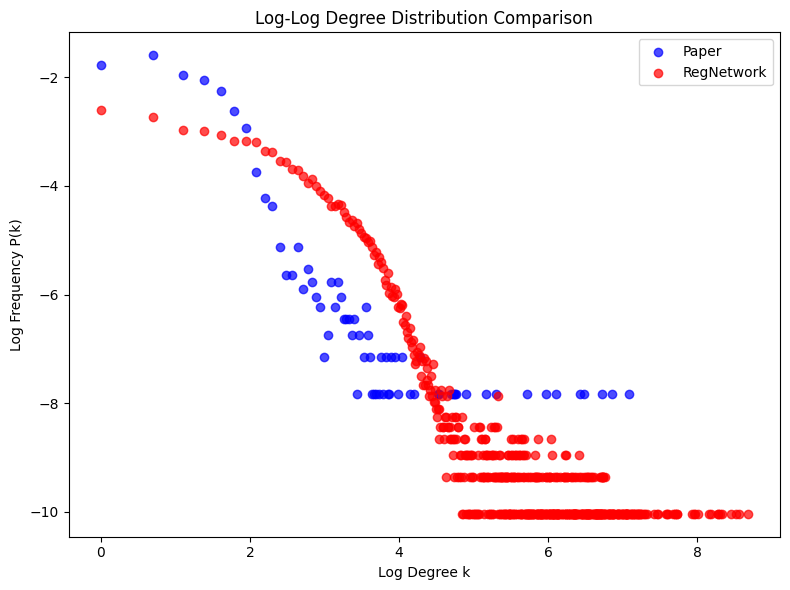

In [71]:
gg.compare_degree_distribution(g_largest_hsapiens,g_regnetwork, 'Paper', 'RegNetwork')

In [ ]:
g_largest_regnetwork = f.get_largest_cc(g_regnetwork)
f.plot_degrees(g_largest_regnetwork, plot_fit=False)
properties_largest_regnetwork = network_properties(g_largest_regnetwork)
properties_largest_regnetwork

In [ ]:
gg.plot_grn_degree(g_largest_regnetwork, plot_network=True, layout='spring')

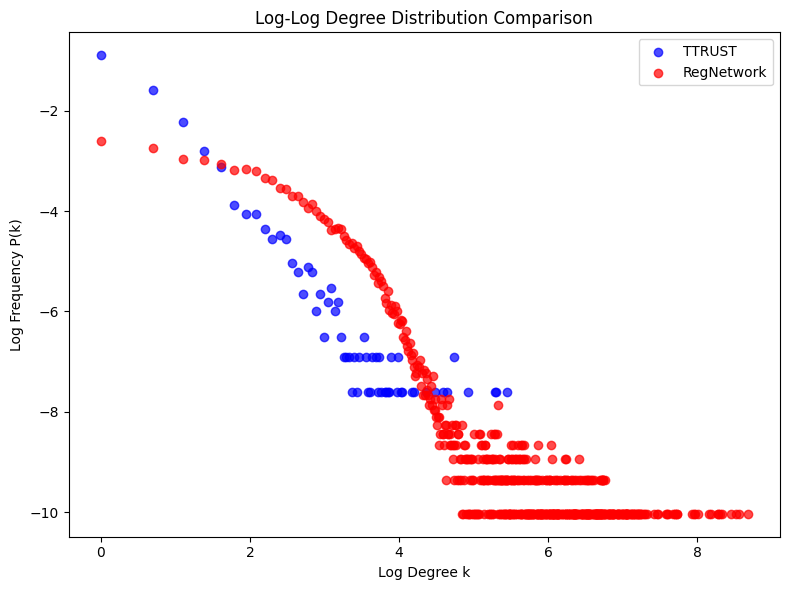

In [74]:
gg.compare_degree_distribution(g_largest_ttrust,g_largest_regnetwork, 'TTRUST', 'RegNetwork')

# End